In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import spikeinterface.full as si
import numpy as np
from pathlib import Path
from spikeinterface.sortingcomponents.peak_detection import detect_peaks
from spikeinterface.sortingcomponents.peak_localization import localize_peaks
from myfigures_interactive import *
from params import *
%matplotlib widget

In [3]:
# Recording path
rec_path = Path('/home/analysis_user/smb4k/NAS5802A5.LOCAL/Public/Neuropixel_Recordings/AreaX-LMAN/Imp_16_08_2022/Recordings/Rec_18_08_2022_g0/')

# Output path
output_path = Path('./test_output/')

In [4]:
# Read recording
rec = si.read_spikeglx(rec_path, stream_id='imec0.ap')
rec_preprocessed = si.bandpass_filter(si.common_reference(rec, reference='local', local_radius=(50, 100)), freq_min=300, freq_max=6000)

/home/analysis_user/Python-related/GitHub/python-neo/neo/rawio/spikeglxrawio.py:262: UserWarning: .meta file has faulty value for .bin file size on disc
  warnings.warn('.meta file has faulty value for .bin file size on disc')


In [5]:
recordings = {'raw':rec,
                'filtered+cmr': rec_preprocessed
                }

In [6]:
# Visualize recording
si.plot_timeseries(recordings, 
                   segment_index=0, 
                   mode='map', # can change to trace
                   order_channel_by_depth=True,
                   backend='ipywidgets')

AppLayout(children=(VBox(children=(FloatSlider(value=0.0, continuous_update=False, description='time:', layout…

### Compute necessary files for peaks/noise visualization

In [7]:
# Noise
noise_file = output_path / 'noise_levels.npy'
if noise_file.exists():
    noise_levels = np.load(noise_file)
else:
    noise_levels = si.get_noise_levels(rec_preprocessed, return_scaled=False)
    np.save(noise_file, noise_levels)

In [8]:
# Peaks
peaks_file = output_path / 'peaks.npy'
if peaks_file.exists():
    peaks = np.load(peaks_file)
else:
    peaks = detect_peaks(rec_preprocessed, noise_levels=noise_levels, **peak_detection_params, **job_kwargs)
    np.save(peaks_file, peaks)

In [9]:
# Location
location_file = output_path / 'peak_locations.npy'
if location_file.exists():
    peak_locations = np.load(location_file)
else:
    peak_locations = localize_peaks(rec_preprocessed, peaks, **peak_location_params, **job_kwargs)
    np.save(location_file, peak_locations)

In [ ]:
fs = rec_preprocessed.get_sampling_frequency()
t_start=0
t_end=10
t1 = int(t_start * fs)
t2 = int(t_end * fs)

keep = (peaks['sample_ind'] > t1) & (peaks['sample_ind'] < t2)
peaks2 =peaks[keep]
locations2 = peak_locations[keep]

print(peaks2.shape)
print(locations2.shape)


In [ ]:
fs = rec_preprocessed.get_sampling_frequency()
x = peaks['sample_ind'] / fs
print(x[(x > t_start) & (x < t_end)])

In [ ]:
peaks2['sample_ind']/fs

In [ ]:
t_window=0
peaks=0
if (t_window is not None) and (peaks is not None):
    print('hey')

In [ ]:
locations2

In [ ]:
peaks['sample_ind']

In [ ]:
peak_locations['x']

In [ ]:
peaks['channel_ind']

/home/analysis_user/.virtualenvs/py38_sigui/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:412: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


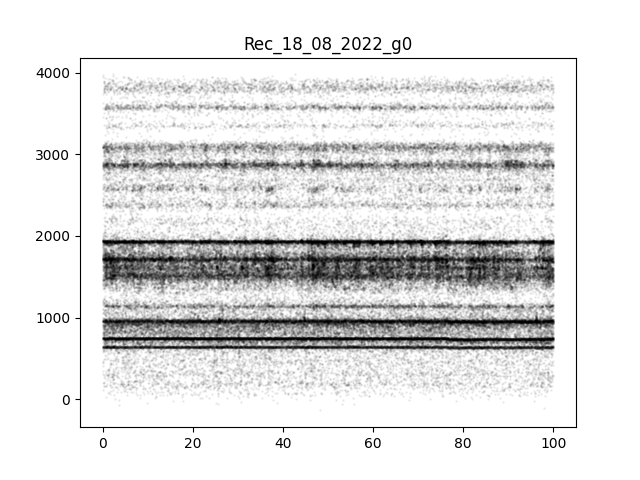

In [10]:
# Visualize
name = Path(rec_path).stem

figure_folder = output_path / 'figures'

plot_drift(peaks, rec_preprocessed, peak_locations, name, figure_folder, time_range=[0,100])

/home/analysis_user/.virtualenvs/py38_sigui/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:412: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


here


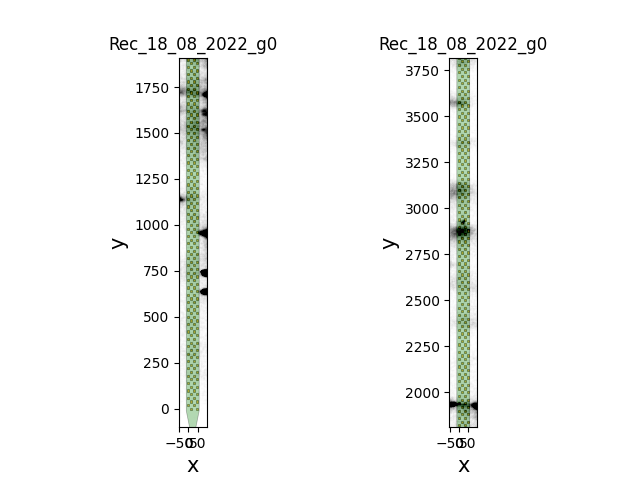

In [43]:
time_range = [0, 200]

fs = rec_preprocessed.get_sampling_frequency()
channel_locs = rec_preprocessed.get_channel_locations()
y_max = np.max(channel_locs[:, 1])/2
y_min = np.min(channel_locs[:, 1])-100

fig, axs = plt.subplots(ncols=2)

x = peak_locations['x']
y = peak_locations['y']

if (time_range is not None) and (peaks is not None):
        print('here')
        peaks_new = peaks['sample_ind'] / fs
        mask = (peaks_new > time_range[0]) & (peaks_new < time_range[1])
        x = x[mask]
        y = y[mask]
    

for number in range(2):
        ax = axs[number]
        plot_probe(rec_preprocessed.get_probe(), ax=ax)
        ax.scatter(x, y, color='k', s=1, alpha=0.002)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title(name)
        ax.set_ylim(y_min, y_max)
        y_min += y_max
        y_max = y_max*2

/home/analysis_user/.virtualenvs/py38_sigui/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:412: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


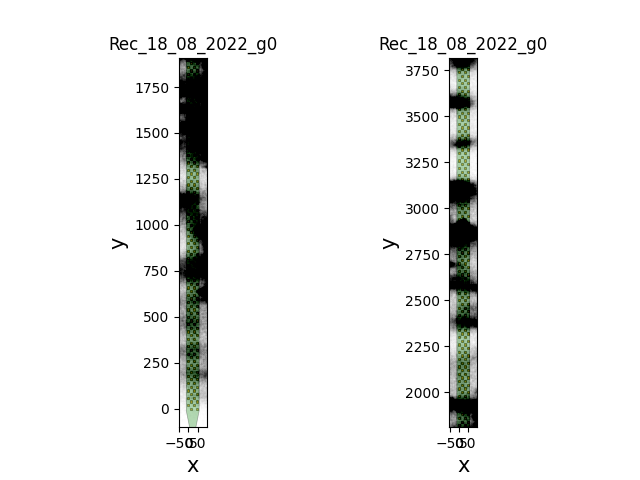

In [14]:
plot_peaks_axis(rec_preprocessed, peak_locations, name, figure_folder, peaks=peaks, time_range=[0,2000])

/home/analysis_user/.virtualenvs/py38_sigui/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:412: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


116939


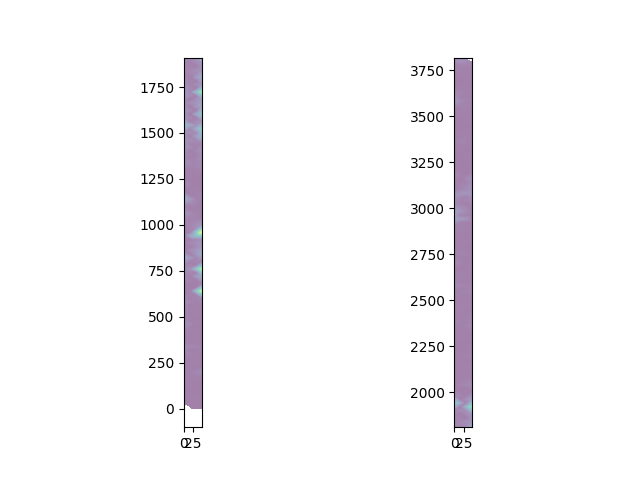

In [25]:
plot_peaks_activity(peaks, rec_preprocessed, peak_locations, name, figure_folder, time_range=[100,200])

In [ ]:
plot_noise(rec_preprocess, figure_folder, with_contact_color=False, with_interpolated_map=True)

In [26]:
si.plot_peak_activity_map?

Signature: si.plot_peak_activity_map(*args, **kwargs)
Docstring:
Plots spike rate (estimated with detect_peaks()) as 2D activity map.

Can be static (bin_duration_s=None) or animated (bin_duration_s=60.)

Parameters
----------
recording: RecordingExtractor
    The recording extractor object.
peaks: None or numpy array
    Optionally can give already detected peaks
    to avoid multiple computation.
detect_peaks_kwargs: None or dict
    If peaks is None here the kwargs for detect_peak function.
weight_with_amplitudes: bool False by default
    Peak are weighted by amplitude
bin_duration_s: None or float
    If None then static image
    If not None then it is an animation per bin.
with_contact_color: bool (default True)
    Plot rates with contact colors
with_interpolated_map: bool (default True)
    Plot rates with interpolated map
with_channel_ids: bool False default
    Add channel ids text on the probe
figure: matplotlib figure
    The figure to be used. If not given a figure is cre